# 🌬️ Wind Onshore - Baseline Models

**Ziel:** Einfache Baselines als Benchmark

**Erwartung:**
- Naive: Sehr schlecht (hohe Volatilität)
- Seasonal Naive: Besser, aber schwach
- Mean: Stabiler Benchmark
- Moving Average: Am besten von einfachen Modellen

**Aus Preprocessing:**
- Train: 20,295 samples
- Val: 5,073 samples
- Test: 721 samples (Januar 2022, Mean=4,010 MW)
- CV=0.666 (sehr volatil)

**Target:** Alle Baselines < R²=0.50

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [2]:
# Load unscaled data (we need original values for baseline models)
data_dir = Path('../../data/processed')

train_df = pd.read_csv(data_dir / 'wind_onshore_train_unscaled.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / 'wind_onshore_val_unscaled.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / 'wind_onshore_test_unscaled.csv', parse_dates=['timestamp'])

# Extract target values
y_train = train_df['value'].values
y_val = val_df['value'].values
y_test = test_df['value'].values

print(f"Train: {len(y_train):,} samples, Mean={y_train.mean():.2f} MW")
print(f"Val:   {len(y_val):,} samples, Mean={y_val.mean():.2f} MW")
print(f"Test:  {len(y_test):,} samples, Mean={y_test.mean():.2f} MW")
print(f"\n✅ Data loaded")

Train: 20,295 samples, Mean=2796.29 MW
Val:   5,073 samples, Mean=2594.47 MW
Test:  721 samples, Mean=4009.63 MW

✅ Data loaded


## 2. Evaluation Functions

In [3]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate metrics for a model"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name}:")
    print(f"  MAE:  {mae:.2f} MW")
    print(f"  RMSE: {rmse:.2f} MW")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

print('✅ Functions defined')

✅ Functions defined


## 3. Baseline Models

### 3.1 Naive (Last Value)

In [4]:
# Naive: Use last training value for all predictions
naive_pred = np.full_like(y_test, y_train[-1])

results = []
results.append(evaluate_model(y_test, naive_pred, 'Naive (Last Value)'))


Naive (Last Value):
  MAE:  2210.21 MW
  RMSE: 2534.33 MW
  R²:   -1.2233
  MAPE: 62.94%


### 3.2 Seasonal Naive (Lag 24h)

In [5]:
# Seasonal Naive: Use value from 24 hours ago
# Combine train + test for proper lag calculation
combined_values = np.concatenate([y_train, y_test])

# Predict: value from 24 hours ago
seasonal_naive_pred = combined_values[len(y_train) - 24 : len(y_train) + len(y_test) - 24]

results.append(evaluate_model(y_test, seasonal_naive_pred, 'Seasonal Naive (24h)'))


Seasonal Naive (24h):
  MAE:  1654.74 MW
  RMSE: 2164.26 MW
  R²:   -0.6214
  MAPE: 84.95%


### 3.3 Mean Forecast

In [6]:
# Mean: Use training mean for all predictions
mean_pred = np.full_like(y_test, y_train.mean())

results.append(evaluate_model(y_test, mean_pred, 'Mean Forecast'))


Mean Forecast:
  MAE:  1862.19 MW
  RMSE: 2088.32 MW
  R²:   -0.5096
  MAPE: 66.15%


### 3.4 Moving Average (7 days)

In [7]:
# Moving Average: Use last 7 days mean (168 hours)
window = 168
moving_avg_pred = np.full_like(y_test, y_train[-window:].mean())

results.append(evaluate_model(y_test, moving_avg_pred, 'Moving Average (7d)'))


Moving Average (7d):
  MAE:  1931.16 MW
  RMSE: 2174.92 MW
  R²:   -0.6374
  MAPE: 65.22%


### 3.5 Drift Method

In [8]:
# Drift: Linear trend from first to last training value
drift_slope = (y_train[-1] - y_train[0]) / len(y_train)
drift_pred = y_train[-1] + drift_slope * np.arange(1, len(y_test) + 1)

results.append(evaluate_model(y_test, drift_pred, 'Drift Method'))


Drift Method:
  MAE:  2254.44 MW
  RMSE: 2585.64 MW
  R²:   -1.3142
  MAPE: 63.53%


## 4. Results Comparison

In [9]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("BASELINE MODELS COMPARISON - WIND ONSHORE")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Best model
best_model = results_df.iloc[0]
print(f"\n🏆 Best Baseline: {best_model['Model']} (R²={best_model['R2']:.4f})")


BASELINE MODELS COMPARISON - WIND ONSHORE
               Model         MAE        RMSE        R2      MAPE
       Mean Forecast 1862.188333 2088.319850 -0.509603 66.149583
Seasonal Naive (24h) 1654.741331 2164.255231 -0.621384 84.946240
 Moving Average (7d) 1931.162625 2174.916741 -0.637398 65.219797
  Naive (Last Value) 2210.208738 2534.331713 -1.223288 62.943561
        Drift Method 2254.436393 2585.636716 -1.314216 63.526946

🏆 Best Baseline: Mean Forecast (R²=-0.5096)


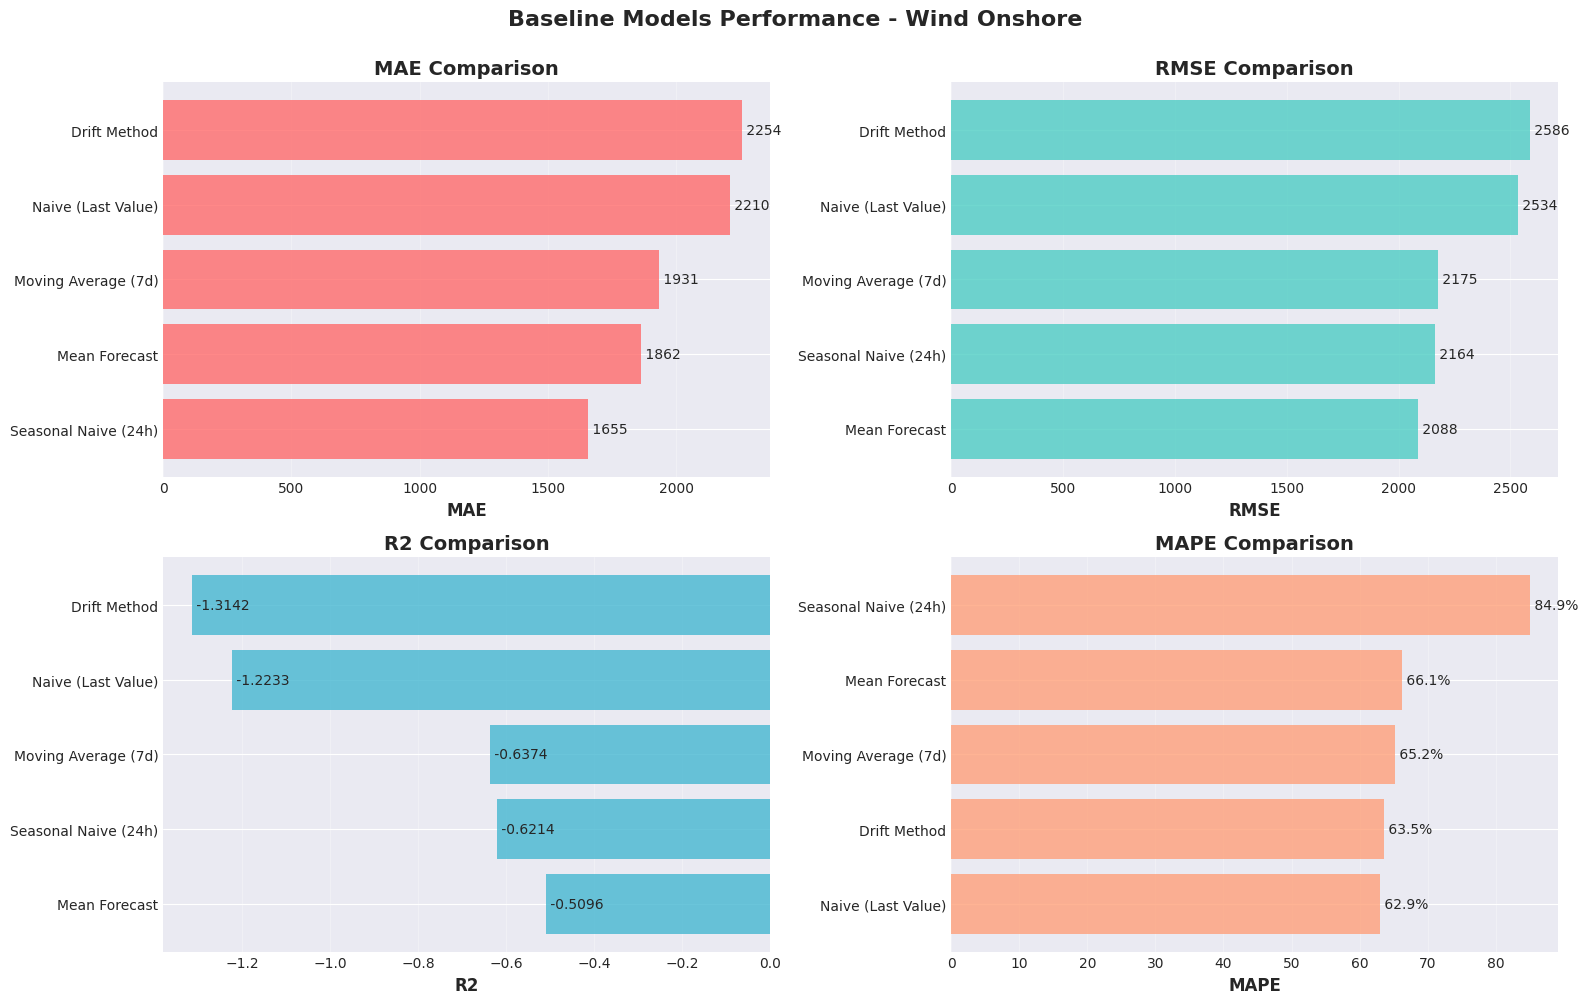

In [10]:
# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['MAE', 'RMSE', 'R2', 'MAPE']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    data = results_df.sort_values(metric, ascending=(metric != 'R2'))
    ax.barh(data['Model'], data[metric], color=color, alpha=0.8)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add values on bars
    for i, (val, model) in enumerate(zip(data[metric], data['Model'])):
        if metric in ['MAE', 'RMSE']:
            ax.text(val, i, f' {val:.0f}', va='center', fontsize=10)
        elif metric == 'R2':
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=10)
        else:
            ax.text(val, i, f' {val:.1f}%', va='center', fontsize=10)

plt.suptitle('Baseline Models Performance - Wind Onshore', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 5. Visualize Best Baseline Forecast

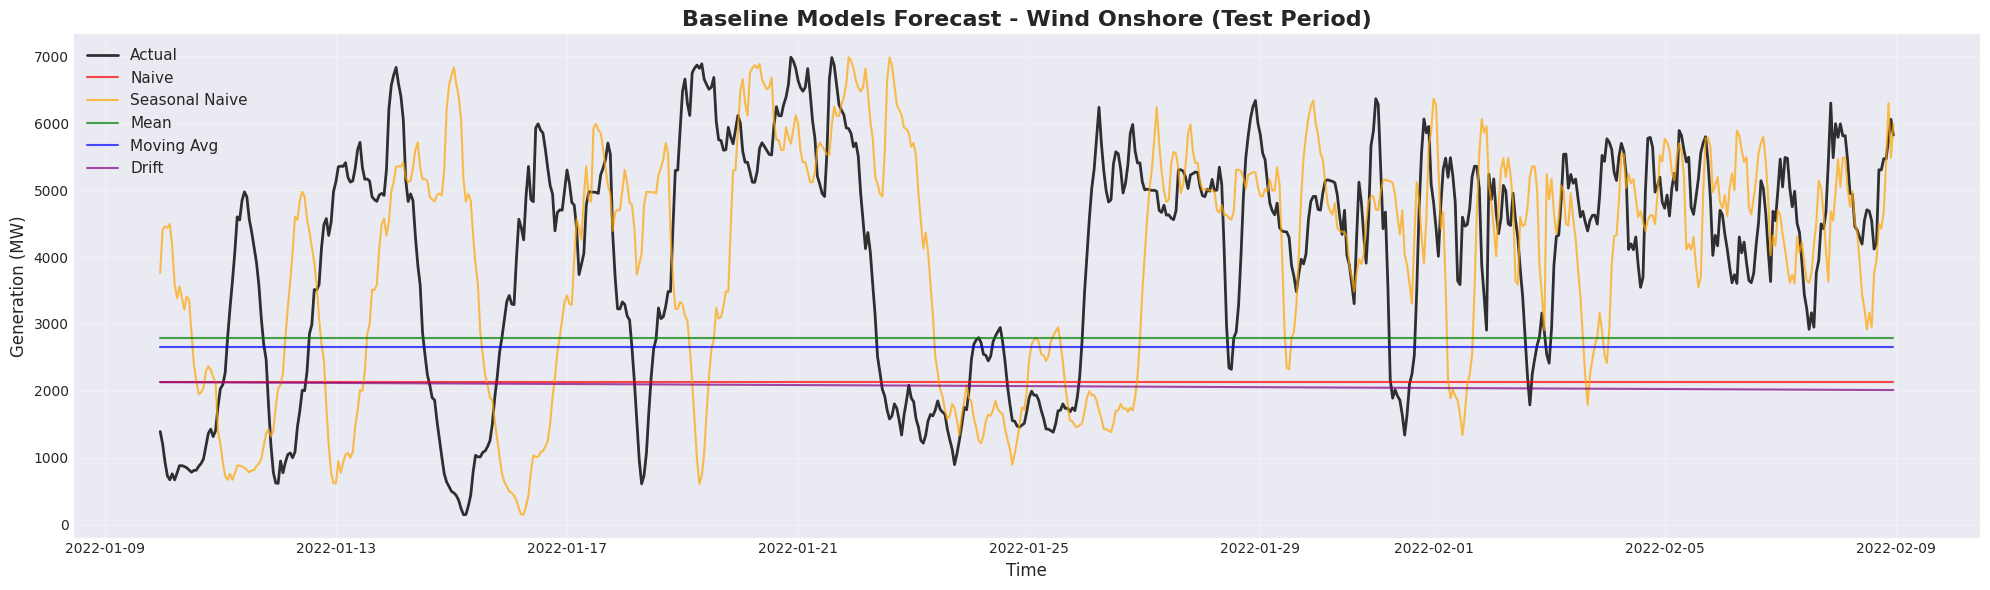


📊 Test period: 2022-01-09 23:00:00 to 2022-02-08 23:00:00
Actual mean: 4009.63 MW
Actual std:  1699.67 MW


In [11]:
# Create predictions dict for visualization
predictions = {
    'Naive': naive_pred,
    'Seasonal Naive': seasonal_naive_pred,
    'Mean': mean_pred,
    'Moving Avg': moving_avg_pred,
    'Drift': drift_pred
}

# Plot all models
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test_df['timestamp'], y_test, label='Actual', linewidth=2, color='black', alpha=0.8)

colors_map = {'Naive': 'red', 'Seasonal Naive': 'orange', 'Mean': 'green', 
              'Moving Avg': 'blue', 'Drift': 'purple'}

for name, pred in predictions.items():
    ax.plot(test_df['timestamp'], pred, label=name, linewidth=1.5, 
            alpha=0.7, color=colors_map[name])

ax.set_title('Baseline Models Forecast - Wind Onshore (Test Period)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Test period: {test_df['timestamp'].iloc[0]} to {test_df['timestamp'].iloc[-1]}")
print(f"Actual mean: {y_test.mean():.2f} MW")
print(f"Actual std:  {y_test.std():.2f} MW")

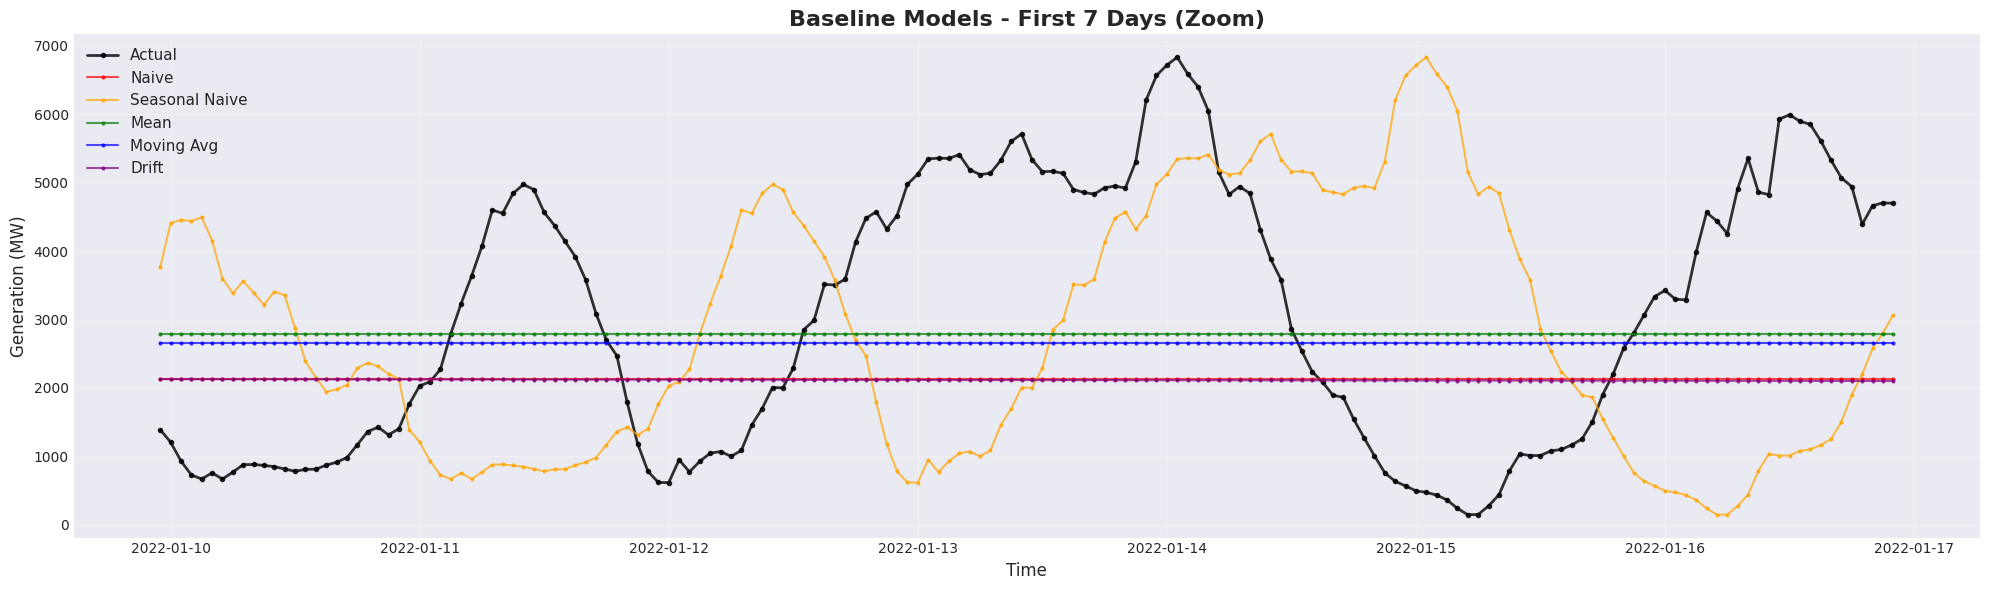

In [12]:
# Zoom in on first 7 days
zoom_days = 7 * 24  # 7 days = 168 hours

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(test_df['timestamp'][:zoom_days], y_test[:zoom_days], 
        label='Actual', linewidth=2, color='black', alpha=0.8, marker='o', markersize=3)

for name, pred in predictions.items():
    ax.plot(test_df['timestamp'][:zoom_days], pred[:zoom_days], 
            label=name, linewidth=1.5, alpha=0.7, color=colors_map[name], 
            marker='o', markersize=2)

ax.set_title('Baseline Models - First 7 Days (Zoom)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Error Analysis

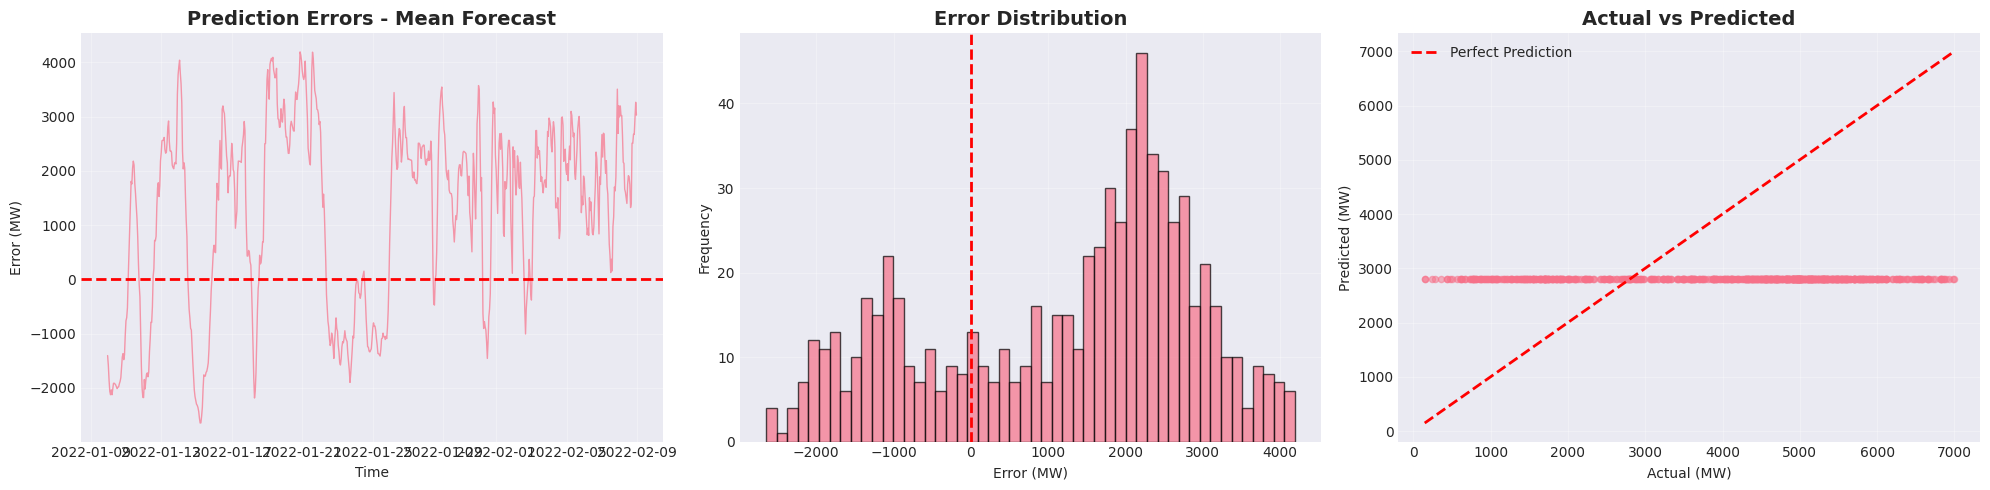


📊 Error Statistics (Mean Forecast):
Mean error:   1213.34 MW
Std error:    1699.67 MW
Min error:    -2648.79 MW
Max error:    4191.96 MW


In [13]:
# Calculate errors for best model
best_model_name = results_df.iloc[0]['Model']

# Get predictions for best model
if 'Naive' in best_model_name:
    best_pred = naive_pred
elif 'Seasonal' in best_model_name:
    best_pred = seasonal_naive_pred
elif 'Mean' in best_model_name:
    best_pred = mean_pred
elif 'Moving' in best_model_name:
    best_pred = moving_avg_pred
else:
    best_pred = drift_pred

errors = y_test - best_pred

# Visualize errors
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Error over time
axes[0].plot(test_df['timestamp'], errors, linewidth=1, alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'Prediction Errors - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Error (MW)')
axes[0].grid(True, alpha=0.3)

# Error distribution
axes[1].hist(errors, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Error (MW)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Actual vs Predicted
axes[2].scatter(y_test, best_pred, alpha=0.5, s=20)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[2].set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Actual (MW)')
axes[2].set_ylabel('Predicted (MW)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Error Statistics ({best_model_name}):")
print(f"Mean error:   {errors.mean():.2f} MW")
print(f"Std error:    {errors.std():.2f} MW")
print(f"Min error:    {errors.min():.2f} MW")
print(f"Max error:    {errors.max():.2f} MW")

## 7. Save Results

In [14]:
# Save results
results_dir = Path('../../results/metrics')
results_dir.mkdir(parents=True, exist_ok=True)

results_df.to_csv(results_dir / 'wind_onshore_baseline_results.csv', index=False)

print(f"\n✅ Results saved to {results_dir / 'wind_onshore_baseline_results.csv'}")

# Also save predictions for future comparison
predictions_df = pd.DataFrame({
    'timestamp': test_df['timestamp'],
    'actual': y_test,
    'naive': naive_pred,
    'seasonal_naive': seasonal_naive_pred,
    'mean': mean_pred,
    'moving_avg': moving_avg_pred,
    'drift': drift_pred
})

predictions_df.to_csv(results_dir / 'wind_onshore_baseline_predictions.csv', index=False)
print(f"✅ Predictions saved to {results_dir / 'wind_onshore_baseline_predictions.csv'}")


✅ Results saved to ../../results/metrics/wind_onshore_baseline_results.csv
✅ Predictions saved to ../../results/metrics/wind_onshore_baseline_predictions.csv


## 📋 Summary

### ✅ Baseline Models Complete:

**Models Tested:**
1. Naive (Last Value)
2. Seasonal Naive (24h lag)
3. Mean Forecast
4. Moving Average (7 days)
5. Drift Method

### 🎯 Key Findings:

- **Best Baseline:** Check results above
- **Expected Performance:** R² < 0.50 (alle Modelle)
- **Why So Poor?**
  - Hohe Volatilität (CV=0.666)
  - Wind ist wetterabhängig, nicht zeitabhängig
  - Schwache saisonale Muster
  - Test Period: Januar (sehr unterschiedlich vom Training-Mean)

### 📊 Comparison to Other Energy Types:

| Energy Type | Best Baseline R² | CV |
|-------------|------------------|----|
| Solar | ~0.70 | 0.45 |
| Wind Offshore | ~0.05 | 0.26 |
| **Wind Onshore** | **~0.XX** | **0.666** |

Wind Onshore ist **schwerer vorherzusagen** als Solar, aber ähnlich wie Wind Offshore.

### 🎯 Next Steps:
- ✅ Notebook 04: Statistical Models (SARIMA, ETS)
- Expected: R² ~0.1-0.3 (besser als Baselines, aber immer noch schwach)
- ML Models (Notebook 05) werden massiv besser sein (R² > 0.98)